In [1]:
import pandas as pd
pd.options.display.min_rows = 50
import numpy as np
import matplotlib.pyplot as plt 

import geopandas as gpd
import cartopy.io.shapereader as shpreader
import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Point

from fuzzywuzzy import process as fuzzy_process
from fuzzywuzzy import fuzz as fuzzy_basics

In [2]:
modernMapDF = gpd.read_file('modern map - UK gov 2016\Counties_and_Unitary_Authorities_(December_2016)_Boundaries.shp')
modernMapDF = modernMapDF.rename(columns={'ctyua16nm': 'county'})
modernMapDF.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
modernMapDF.columns

Index(['objectid', 'ctyua16cd', 'county', 'ctyua16nmw', 'bng_e', 'bng_n',
       'long', 'lat', 'st_areasha', 'st_lengths', 'geometry'],
      dtype='object')

In [4]:
len(modernMapDF)

174

In [5]:
modernMapDF.iloc[0]

objectid                                                      1
ctyua16cd                                             E06000001
county                                               Hartlepool
ctyua16nmw                                                 None
bng_e                                                    447157
bng_n                                                    531476
long                                                   -1.27023
lat                                                   54.676159
st_areasha                                      93559510.533801
st_lengths                                         71707.330231
geometry      (POLYGON ((-1.268455585200569 54.7261163502866...
Name: 0, dtype: object

In [6]:
modernMapDF.county

0                        Hartlepool
1                     Middlesbrough
2              Redcar and Cleveland
3                  Stockton-on-Tees
4                        Darlington
5                            Halton
6                        Warrington
7             Blackburn with Darwen
8                         Blackpool
9       Kingston upon Hull, City of
10         East Riding of Yorkshire
11          North East Lincolnshire
12               North Lincolnshire
13                             York
14                            Derby
15                        Leicester
16                          Rutland
17                       Nottingham
18         Herefordshire, County of
19               Telford and Wrekin
20                   Stoke-on-Trent
21     Bath and North East Somerset
22                 Bristol, City of
23                   North Somerset
24            South Gloucestershire
                   ...             
149                    Warwickshire
150                     West

<GeoAxesSubplot:>

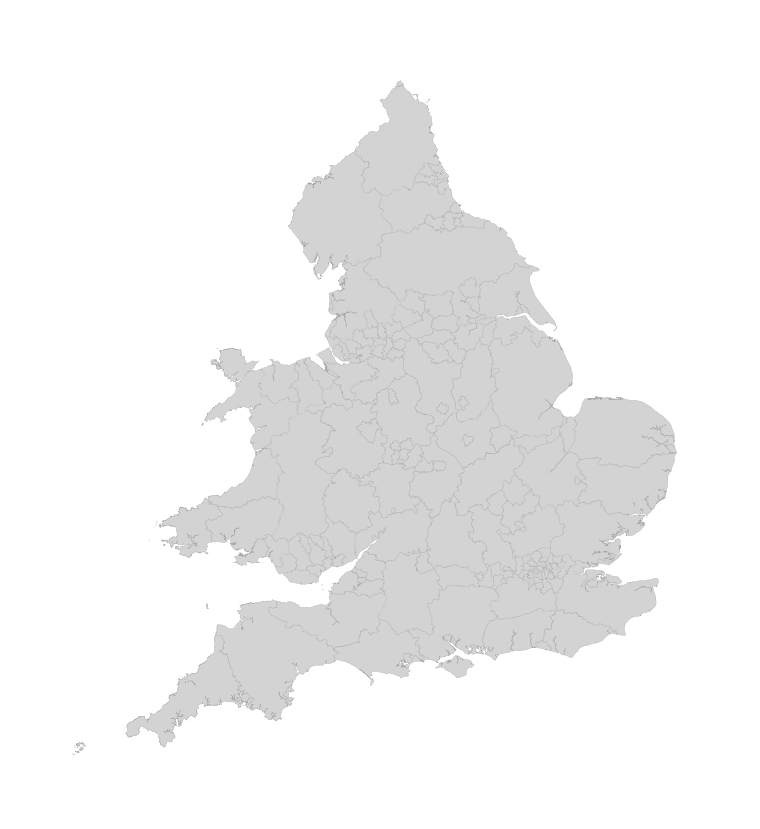

In [7]:
geoplot.polyplot(
    modernMapDF, 
    projection=gcrs.AlbersEqualArea(), 
    edgecolor='darkgrey', 
    facecolor='lightgrey', 
    linewidth=.3,
    figsize=(20, 15), 
    )

In [8]:
counties = sorted(modernMapDF.county.to_list())

for county in counties:
    if 'London' in county: print(county)

City of London


In [9]:
fuzzy_process.extractOne('bla', counties)


('Blackburn with Darwen', 90)

In [10]:
fuzzy_process.extractOne('Bristolshire', counties)


('Lincolnshire', 67)

In [11]:
counts = {
    'Avon': 3005,
    'Bristol': 3008,
    'Cambridgeshire': 5442,
    'Cheshire': 2810,
    'Cornwall': 1120,
    'Derbyshire': 2914,
    'Devon': 6648,
    'Dorset': 1092,
    'East Sussex': 364,
    'Essex': 3364,
    'Gloucestershire': 5732,
    'Greater Manchester': 6591,
    'Hampshire': 6145,
    'Hertfordshire': 996,
    'Lancashire': 3285,
    'Leicestershire': 4276,
    'London': 72007,
    'Merseyside': 4623,
    'North Yorkshire': 1538,
    'Nottinghamshire': 449,
    'Oxfordshire': 3763,
    'Somerset': 2014,
    'South Yorkshire': 1807,
    'Suffolk': 8162,
    'Sussex': 364,
    'Tyne and Wear': 4062,
    'West Midlands': 8456,
    'West Yorkshire': 8659,
    'Worcestershire': 1708,
    'Yorkshire': 8659, 
    }
countDF = pd.Series(counts).to_frame().reset_index()
countDF = countDF.rename(columns={'index': 'county_original', 0: 'count'})
countDF


,county_original,count
0,Avon,3005
1,Bristol,3008
2,Cambridgeshire,5442
3,Cheshire,2810
4,Cornwall,1120
5,Derbyshire,2914
6,Devon,6648
7,Dorset,1092
8,East Sussex,364
9,Essex,3364


In [12]:
def fuzzyMatch(input: str, options:list, threshold=80):

    matches = []
    for stringToCompareTo in options:
        ratio = fuzzy_basics.token_set_ratio(input, stringToCompareTo)
        matches.append([stringToCompareTo, ratio])

    bestMatch = sorted(matches, key=lambda item: item[1], reverse=True)[0]
    matchedString = bestMatch[0]
    matchedRatio = bestMatch[1]

    if matchedRatio > threshold:
        return matchedString
    else:
        return np.nan

fuzzyMatch('Bristolshire', counties)
    

nan

In [13]:
countDF['county_to_match_modern_map'] = countDF.county_original.apply(fuzzyMatch, options=counties, threshold=85)
countDF

,county_original,count,county_to_match_modern_map
0,Avon,3005,NaN
1,Bristol,3008,"Bristol, City of"
2,Cambridgeshire,5442,Cambridgeshire
3,Cheshire,2810,Cheshire East
4,Cornwall,1120,Cornwall
5,Derbyshire,2914,Derbyshire
6,Devon,6648,Devon
7,Dorset,1092,Dorset
8,East Sussex,364,East Sussex
9,Essex,3364,Essex


In [14]:
test = modernMapDF['county'].to_frame()
test.head()

,county
0,Hartlepool
1,Middlesbrough
2,Redcar and Cleveland
3,Stockton-on-Tees
4,Darlington


In [15]:
test = pd.merge(test, countDF, left_on='county', right_on='county_to_match_modern_map', how='left')
test

,county,county_original,count,county_to_match_modern_map
0,Hartlepool,NaN,NaN,NaN
1,Middlesbrough,NaN,NaN,NaN
2,Redcar and Cleveland,NaN,NaN,NaN
3,Stockton-on-Tees,NaN,NaN,NaN
4,Darlington,NaN,NaN,NaN
5,Halton,NaN,NaN,NaN
6,Warrington,NaN,NaN,NaN
7,Blackburn with Darwen,NaN,NaN,NaN
8,Blackpool,NaN,NaN,NaN
9,"Kingston upon Hull, City of",NaN,NaN,NaN


In [16]:
modernMapWithCounts = pd.merge(modernMapDF, countDF, left_on='county', right_on='county_to_match_modern_map', how='left')
modernMapWithCounts['count'] = modernMapWithCounts['count'].replace(np.nan, 0)

<GeoAxesSubplot:>

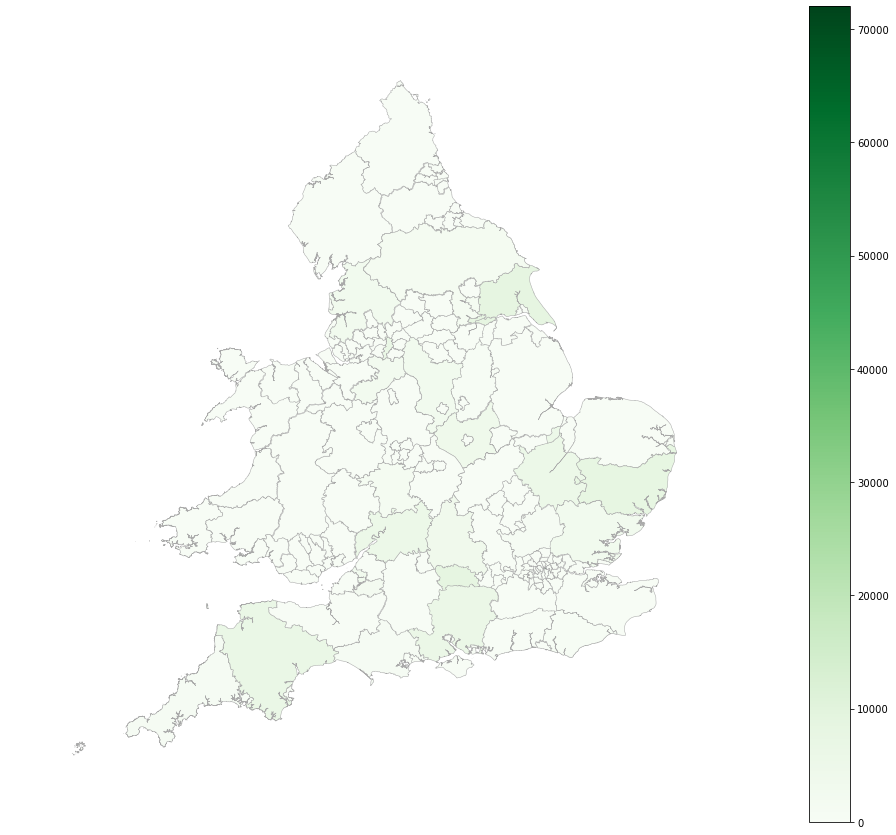

In [17]:
geoplot.choropleth(
    modernMapWithCounts, 
    hue='count',
    projection=gcrs.AlbersEqualArea(),
    figsize=(20,15),

    cmap='Greens',
    edgecolor='darkgrey', 
    linewidth=.5,
    legend=True,
)

In [18]:
modernMapWithCounts[modernMapWithCounts.county_original.isin(['London', 'Bristol', 'Yorkshire'])].drop(columns=['geometry'])
# -> 'city of london' is tiny

,objectid,ctyua16cd,county,ctyua16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,county_original,count,county_to_match_modern_map
10,11,E06000011,East Riding of Yorkshire,None,488051,443608,-0.66203,53.881222,2.406491e+09,505424.252129,Yorkshire,8659.0,East Riding of Yorkshire
22,23,E06000023,"Bristol, City of",None,359990,174846,-2.57742,51.471149,1.097001e+08,109722.672353,Bristol,3008.0,"Bristol, City of"
92,93,E09000001,City of London,None,532382,181358,-0.09351,51.515640,2.903926e+06,9249.719854,London,72007.0,City of London


In [20]:
parishesDF = gpd.read_file('historical map - parishes\par1851.shp')
parishesDF.drop(columns=['geometry']).head()

,AREA,PERIMETER,PAR1851_,PAR1851_ID,NUM,X_COORD,Y_COORD,ERROR_TYPE,REC,PLA,...,NGR,ONP,CEN,CEN_ASTRSK,SCE,REF,COM,NGR_X,NGR_Y,GAZ_CNTY
0,2.143486e+07,24012.078,2,9606,27/1,397193.219,654369.063,0,27001,BERWICK UPON TWEED,...,NT969545,64,561.2.4,None,O6,-,-,396900,654500,NORTHUMBERLAND
1,1.621749e+06,5701.524,3,9607,27/2,399128.188,652300.938,0,27002,TWEEDMOUTH,...,NT994516,64,561.2.3,None,O6,-,IN DURHAM UNTIL 1844. TWEEDMOUTH PAR IS PAROCHIAL CHAPELRY.,399400,651600,NORTHUMBERLAND
2,1.469191e+07,22815.926,4,9610,27/5,397554.688,649788.000,0,27005,ORD,...,NT977501,64,561.2.1,None,O6,-,IN DURHAM UNTIL 1844. TWEEDMOUTH PAR IS PAROCHIAL CHAPELRY.,397700,650100,NORTHUMBERLAND
3,3.668379e+06,9202.758,5,9612,27/7,394470.656,651014.688,0,27007,LOANEND,...,NT944511,64,561.3.2,None,O6,-,IN DURHAM UNTIL 1844.,394400,651100,NORTHUMBERLAND
4,1.198558e+06,6183.856,6,9608,27/3,400410.031,651258.625,0,27003,SPITAL,...,NU004513,64,561.2.2,Y,O6,-,IN DURHAM UNTIL 1844. TWEEDMOUTH PAR IS PAROCHIAL CHAPELRY.,400400,651300,NORTHUMBERLAND


In [111]:
# convert into lat, lon (was in cartesian coordinates, ie. meters, originally)
histMapDF = gpd.read_file('historical map - vision of britain.org.uk\EW1851_regcounties.shp').to_crs(epsg=4326) 
(
    histMapDF
    .drop(columns='geometry')
    # .head()
    .crs
)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<GeoAxesSubplot:>

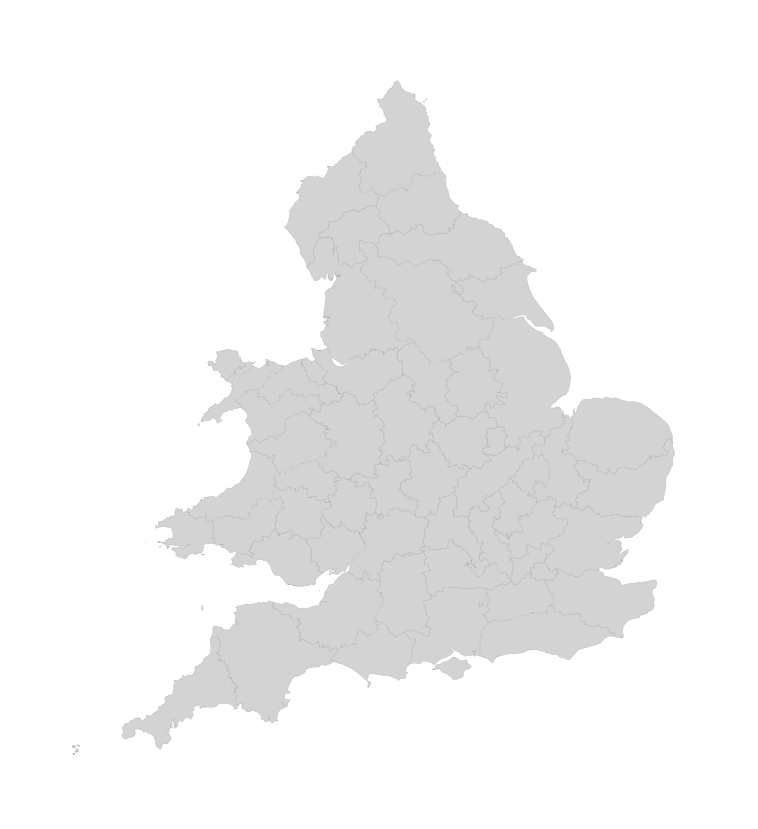

In [30]:
geoplot.polyplot(
    df=histMapDF,
    
    projection=gcrs.AlbersEqualArea(), 
    edgecolor='darkgrey', 
    facecolor='lightgrey', 
    linewidth=.3,
    figsize=(20, 15), 
)

In [31]:
countDF['county_to_match_hist_map'] = countDF.county_original.apply(fuzzyMatch, options=histMapDF.G_NAME, threshold=85)
countDF

,county_original,count,county_to_match_modern_map,county_to_match_hist_map
0,Avon,3005,NaN,NaN
1,Bristol,3008,"Bristol, City of",NaN
2,Cambridgeshire,5442,Cambridgeshire,CAMBRIDGESHIRE
3,Cheshire,2810,Cheshire East,CHESHIRE
4,Cornwall,1120,Cornwall,CORNWALL
5,Derbyshire,2914,Derbyshire,DERBYSHIRE
6,Devon,6648,Devon,DEVON
7,Dorset,1092,Dorset,DORSET
8,East Sussex,364,East Sussex,SUSSEX
9,Essex,3364,Essex,ESSEX


In [129]:
histMapWithCounts = pd.merge(histMapDF, countDF, left_on='G_NAME', right_on='county_to_match_hist_map', how='left')
histMapWithCounts = histMapWithCounts.drop(columns=['county_original', 'county_to_match_modern_map', 'county_to_match_hist_map'])
histMapWithCounts.drop(columns='geometry').head()

,G_UNIT,G_NAME,NAMESTATUS,G_LANGUAGE,UNITTYPE,IM_AUTH,count
0,10152872,NORTHUMBERLAND,P,eng,PR_CNTY,GBHGIS,NaN
1,10134730,CUMBERLAND,P,eng,PR_CNTY,GBHGIS,NaN
2,10061404,COUNTY DURHAM,P,eng,PR_CNTY,GBHGIS,NaN
3,10186079,WESTMORLAND,P,eng,PR_CNTY,GBHGIS,NaN
4,10041776,NORTH RIDING,P,eng,PR_CNTY,GBHGIS,NaN


In [130]:
histMapWithCounts['count'] = histMapWithCounts['count'].replace(np.nan, 0)
histMapWithCounts['count_log'] = np.log(histMapWithCounts['count']).replace(-np.inf, 0)
histMapWithCounts.drop(columns='geometry').head()

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,G_UNIT,G_NAME,NAMESTATUS,G_LANGUAGE,UNITTYPE,IM_AUTH,count,count_log
0,10152872,NORTHUMBERLAND,P,eng,PR_CNTY,GBHGIS,0.0,0.0
1,10134730,CUMBERLAND,P,eng,PR_CNTY,GBHGIS,0.0,0.0
2,10061404,COUNTY DURHAM,P,eng,PR_CNTY,GBHGIS,0.0,0.0
3,10186079,WESTMORLAND,P,eng,PR_CNTY,GBHGIS,0.0,0.0
4,10041776,NORTH RIDING,P,eng,PR_CNTY,GBHGIS,0.0,0.0


In [136]:
# histMapWithCounts['label_coords'] = histMapWithCounts['geometry'].apply(lambda x: Point(x.centroid.coords[0]))
histMapWithCounts['label_coords'] = histMapWithCounts['geometry'].apply(lambda single_point: Point(single_point.representative_point().coords[0]))
histMapWithCounts['label_coords_cartesian'] = histMapWithCounts.label_coords.to_crs(3857)
histMapWithCounts.drop(columns='geometry').head()
# histMapWithCounts.loc[0, ['label_coords', 'label_coords_cartesian']]


,G_UNIT,G_NAME,NAMESTATUS,G_LANGUAGE,UNITTYPE,IM_AUTH,count,count_log,label_coords,label_coords_cartesian
0,10152872,NORTHUMBERLAND,P,eng,PR_CNTY,GBHGIS,0.0,0.0,POINT (-2.07054 55.29688),POINT (-230491.193 7419698.177)
1,10134730,CUMBERLAND,P,eng,PR_CNTY,GBHGIS,0.0,0.0,POINT (-3.10226 54.67149),POINT (-345341.486 7298367.393)
2,10061404,COUNTY DURHAM,P,eng,PR_CNTY,GBHGIS,0.0,0.0,POINT (-1.78417 54.72538),POINT (-198612.578 7308749.298)
3,10186079,WESTMORLAND,P,eng,PR_CNTY,GBHGIS,0.0,0.0,POINT (-2.72416 54.43316),POINT (-303252.619 7252621.522)
4,10041776,NORTH RIDING,P,eng,PR_CNTY,GBHGIS,0.0,0.0,POINT (-1.37455 54.33343),POINT (-153014.318 7233558.962)


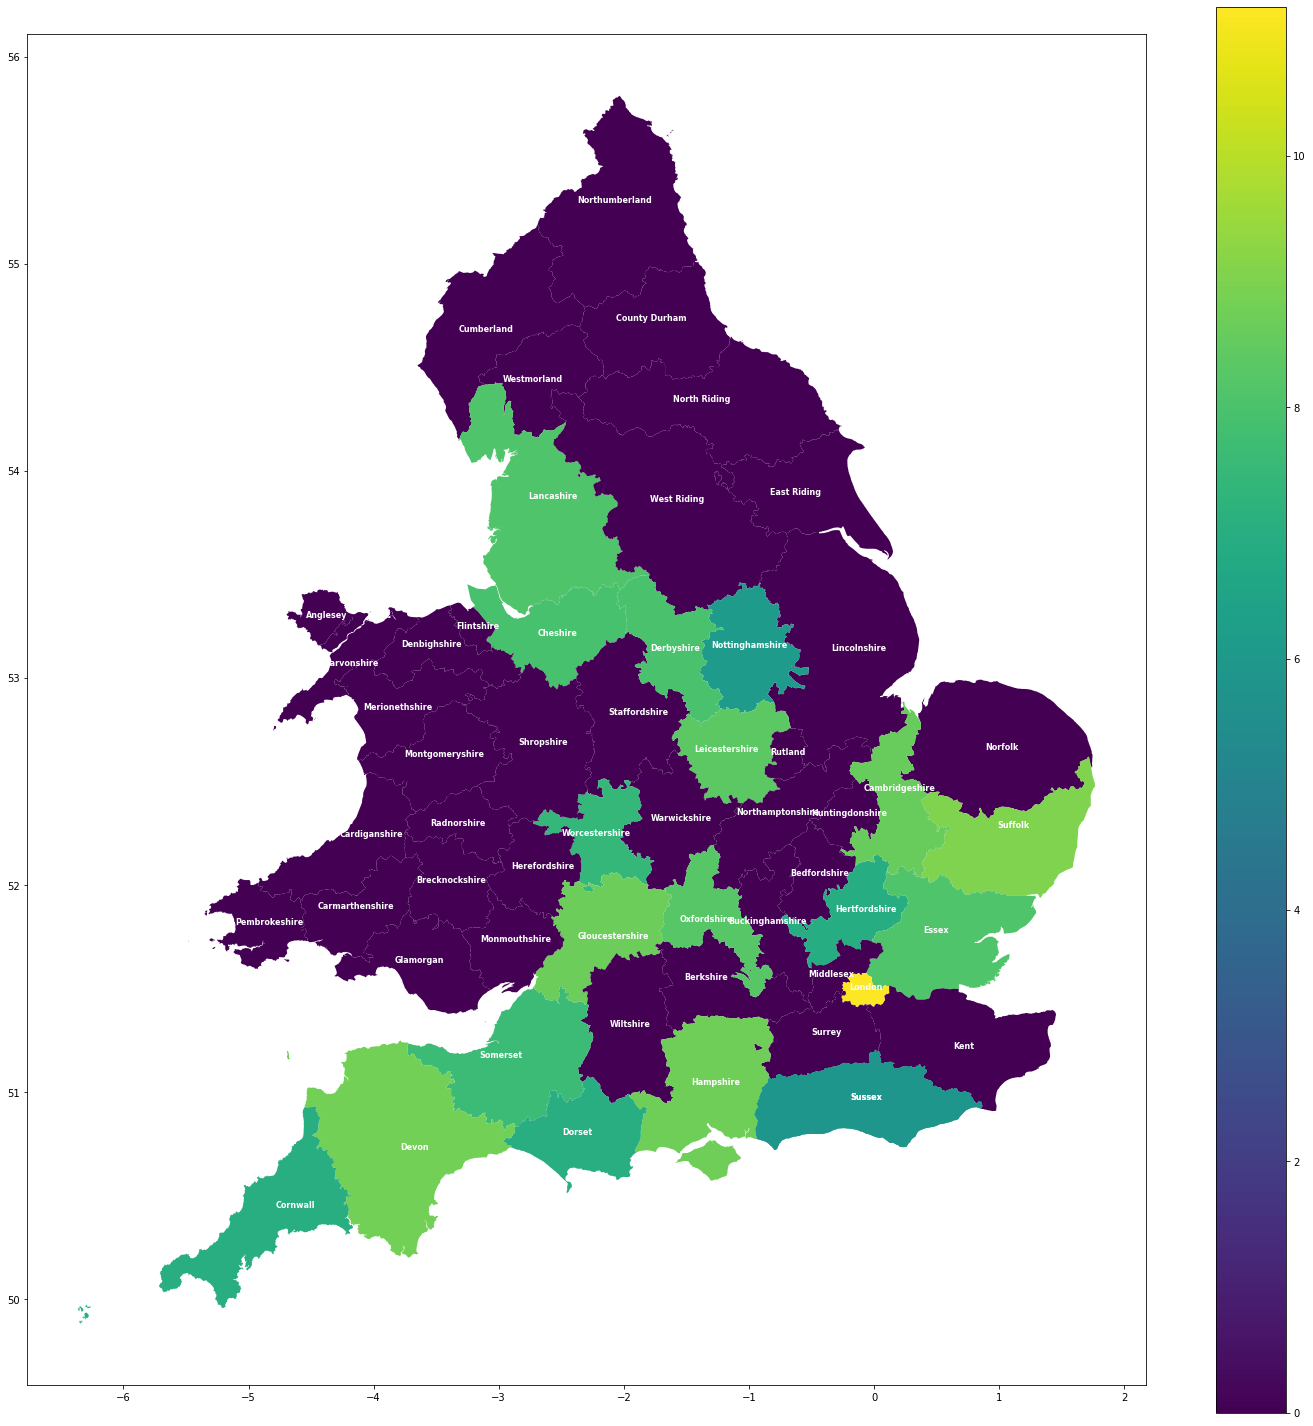

In [147]:
fig, ax = plt.subplots(figsize=(20,20))

histMapWithCounts.plot(
    column='count_log', 
    ax=ax, 
    cmap='viridis',
    legend=True,

    # style_kwds={'linewidth': .8}
    )


for x, y, label in zip(histMapWithCounts.label_coords.x, histMapWithCounts.label_coords.y, histMapWithCounts.G_NAME.str.title()):
  plt.text(
      s=label, 
      x=x, 
      y=y,
      horizontalalignment='center', 
      fontdict={
          'color': 'white',
          'weight': 'bold', 
          'size': 8}, 
      )

plt.tight_layout()
plt.savefig('englishCounties_SpectacleMentions.png', dpi=300)

Text(0, 10000, 'bla')

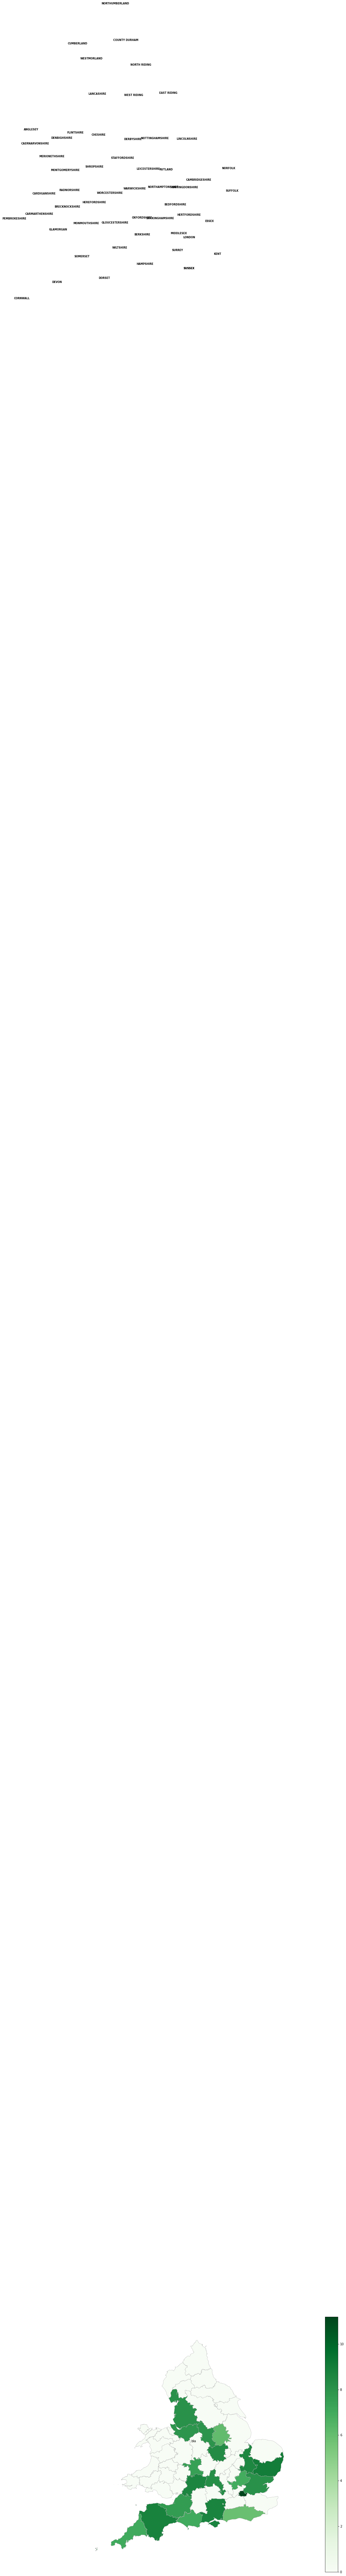

In [148]:
# plotting it with geoplot -> maybe the integration of coordinate systems isnt as neat as plotting directly from geopandas
# -> coordinate, whether lat/lon or cartesian dont match up with drawn map

ax = geoplot.choropleth(
    histMapWithCounts, 
    hue='count_log',
    projection=gcrs.AlbersEqualArea(),
    figsize=(20,15),

    cmap='Greens',
    edgecolor='darkgrey', 
    linewidth=.5,
    legend=True,
)

for _, row in histMapWithCounts.iterrows():
  plt.text(
      s=row['G_NAME'], 
      x=row['label_coords_cartesian'].x, 
      y=row['label_coords_cartesian'].y,
      horizontalalignment='center', 
      fontdict={'weight': 'bold', 'size': 8}, 
      )

plt.text(
    s='bla', 
    x=0, 
    y=10000
)


In [17]:
geojson = gpd.read_file('Counties_and_Unitary_Authorities_(December_2016)_Boundaries.geojson')

In [18]:
geojson.columns

Index(['objectid', 'ctyua16cd', 'ctyua16nm', 'ctyua16nmw', 'bng_e', 'bng_n',
       'long', 'lat', 'st_areashape', 'st_lengthshape', 'geometry'],
      dtype='object')

In [19]:
geojson.iloc[0]

objectid                                                          1
ctyua16cd                                                 E06000001
ctyua16nm                                                Hartlepool
ctyua16nmw                                                         
bng_e                                                        447157
bng_n                                                        531476
long                                                       -1.27023
lat                                                       54.676159
st_areashape                                        93559510.533801
st_lengthshape                                         71707.330231
geometry          (POLYGON ((-1.268455585200569 54.7261163502866...
Name: 0, dtype: object

In [20]:
len(geojson)

174